In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
from scipy.stats import pearsonr
import pingouin as pg
sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})
sns.set_context('notebook')
sns.set_style("ticks")


# Functions

In [2]:
# ------------------------------------------------------------------------------------------------------------
# Cleaning functions
# ------------------------------------------------------------------------------------------------------------
def get_max_payoff(f1, f2, cost1=0, cost2=0):
    data = np.zeros((11-cost2, 11-cost1))
    for i in range(11-cost1):
        for j in range(11-cost2):
            data[j, i] = 10 - i - cost1 + ((i*f1 + j*f2)/2)
    return np.amax(data)


def add_max_payoff(df, cost=None, with_group=True):
    if with_group:
        group_ids = df['group_id'].unique()
    f1, f2 = sorted(df['multiplier'].unique())
    df['max_payoff'] = np.NaN
    matching = {}
    for m1, m2 in ((f1, f2), (f1, f1), (f2, f1), (f2, f2)):
        matching[(m1, m2)] = [get_max_payoff(m1, m2), get_max_payoff(m2, m1)]

    if not with_group:
        for i, d in df.iterrows():
            t1 = d['multiplier']
            t2 = d['opp_multiplier']
            c1 = d['disclose']
            c2 = d['opp_disclose']

            max_payoff = matching[t1, t2]

            if cost:
                max_payoff = [get_max_payoff(t1, t2, cost1=cost*c1, cost2=c2*cost),
                              get_max_payoff(t2, t1, cost1=cost*c2, cost2=c1*cost)]

            df.loc[i, 'max_payoff'] = max_payoff[0]
            df.loc[i, 'opp_max_payoff'] = max_payoff[1]
        return df 


    for g in group_ids:
        d = df[df['group_id'] == g]
        if len(d) == 2:
            idx = d.index.tolist()
            t1 = d.iloc[0]['multiplier']
            t2 = d.iloc[1]['multiplier']
            c1 = d.iloc[0]['disclose']
            c2 = d.iloc[1]['disclose']

            max_payoff = matching[t1, t2]

            if cost:
                max_payoff = [get_max_payoff(t1, t2, cost1=cost*c1, cost2=c2*cost),
                              get_max_payoff(t2, t1, cost1=cost*c2, cost2=c1*cost)]

            df.loc[idx[0], 'max_payoff'] = max_payoff[0]
            df.loc[idx[1], 'max_payoff'] = max_payoff[1]
    return df


def add_norm_payoff(df, with_opp):
    df['norm_payoff'] = df['payoff']/df['max_payoff']
    if with_opp:
        df['opp_norm_payoff'] = df['opp_payoff']/df['opp_max_payoff']
    return df


def remove_bots(df):
    prolific_id_to_exclude = df[df['rt1'] == -1]['prolific_id'].unique()
    df = df[~df['prolific_id'].isin(prolific_id_to_exclude)]
    return df


def add_subjects(df, num):
    df['id_in_session'] = df['id_in_session'] + (num*100)
    return df


def remove_bots_but_keep_previous_rows(df):
    return df[df['rt1'] != -1]


def remove_trials_where_both_players_are_bots(df):
    group_ids = df['group_id'].unique()
    for g in group_ids:
        d = df[df['group_id'] == g]
        idx = d.index.tolist()
        rt1 = d.iloc[0]['rt1'] == -1
        rt2 = d.iloc[1]['rt1'] == -1
        if rt1 and rt2:
            df = df.drop(idx)
    return df


def remove_incomplete_sub(df, n):
    count = 0
    for i in df['prolific_id'].unique():
        count += len(df[df['prolific_id'] == i]) == n
        if len(df[df['prolific_id'] == i]) != n:
            df = df[df['prolific_id'] != i]
    return df, count


# Data clearning

In [3]:
exp = [
    'data/' + f for f in
    ['theresa_sorting.csv',
     'theresa_control.csv',
     'theresa_with_cost.csv',
     'theresa_single.csv']
]

dfs = [pd.read_csv(f) for f in exp]

for i, d in enumerate(dfs):
    dfs[i] = remove_bots(dfs[i].copy())
    dfs[i], count = remove_incomplete_sub(
        df=dfs[i].copy(), n=63 if i == 3 else 60)
    dfs[i] = add_max_payoff(df=dfs[i].copy(), cost=2 if i == 2 else None, with_group=not i==3)
    dfs[i] = add_norm_payoff(df=dfs[i].copy(), with_opp=i==3)
    print(f'Exp {i}', f'N={count}', f'filename={exp[i]}')

    # df['prolific_id']


/usr/local/lib/python3.8/dist-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


Exp 0 N=30 filename=data/theresa_sorting.csv
Exp 1 N=22 filename=data/theresa_control.csv
Exp 2 N=23 filename=data/theresa_with_cost.csv
Exp 3 N=56 filename=data/theresa_single.csv


# Variables Corr

In [4]:
def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues



selected_exp = 3
df = dfs[selected_exp]
# df = df[df['round_number'] < 30]

x = df.groupby(
    ['prolific_id','multiplier','opp_p_disclose', 'opp_multiplier'], as_index=False
    )[['disclose', 'contribution', 'norm_payoff']].mean()

# y = df.groupby(['prolific_id', 'multiplier' ], as_index=False)['contribution'].mean()

# Compute the correlation matrix
corr = x.corr()
p = calculate_pvalues(x)

# combining text with values
formatted_text = (np.asarray(["{0}\n{1:.2f}".format(
    text, data) for text, data in zip(p.flatten(), corr.flatten())])).reshape(3, 5)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(5, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap,  center=0, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=formatted_text, fmt=".2f")

#
#

AttributeError: 'DataFrame' object has no attribute 'flatten'

# Variables Regressions

/tmp/ipykernel_85807/961297597.py:24: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  plt.gca().spines['left'].set_smart_bounds(True)
/tmp/ipykernel_85807/961297597.py:25: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  plt.gca().spines['bottom'].set_smart_bounds(True)


<Figure size 1200x900 with 0 Axes>

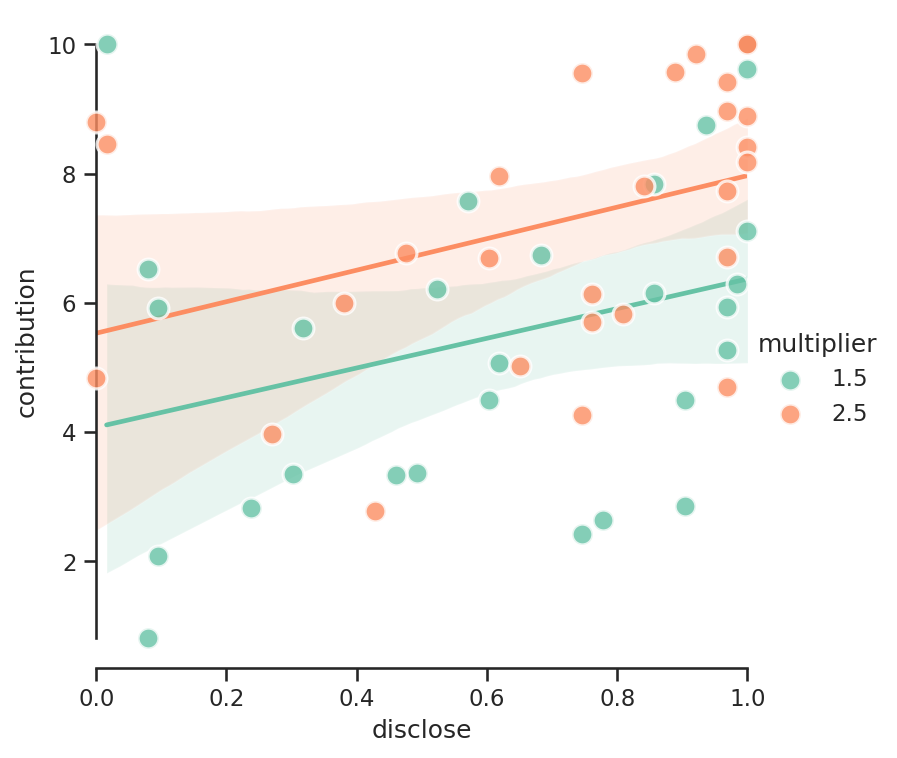

                            OLS Regression Results                            
Dep. Variable:           contribution   R-squared:                       0.237
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     8.252
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           0.000759
Time:                        19:12:44   Log-Likelihood:                -121.18
No. Observations:                  56   AIC:                             248.4
Df Residuals:                      53   BIC:                             254.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.7061      1.263      1.351      0.1

In [7]:
selected_exp = 3
df = dfs[selected_exp]
x = df.groupby(['prolific_id', 'multiplier'], as_index=False)[['disclose', 'contribution', 'norm_payoff', 'payoff']].mean()

# x = x[x['multiplier']==1.5]
# y = df.groupby(['prolific_id', 'multiplier' ], as_index=False)['contribution'].mean()
# x = x[x['disclose'] <= .5]
model1 = smf.ols(formula='contribution ~ disclose + multiplier', data=x).fit()
model2 = smf.ols(formula='norm_payoff ~ disclose * multiplier', data=x).fit()


# fig, axs = plt.subplots(1, 2)
sns.set_palette('Set2')
# sns.regplot(ax=axs[0],
   # x='disclose',
   # y='contribution',  data=x, scatter_kws={'clip_on': False, 'zorder': 10, 'edgecolor': 'white', 'lw': 1.5, 's': 100})
# plt.ylabel('Contribution rate')
plt.figure(figsize=(8, 6))
sns.lmplot(
   x='disclose',
   y='contribution', hue="multiplier", data=x, scatter_kws={'clip_on': False, 'zorder': 10, 'edgecolor': 'white', 'lw': 1.5, 's': 100})
# plt.ylim(.7,1)
# plt.xlim(0,1)
plt.gca().spines['left'].set_smart_bounds(True)
plt.gca().spines['bottom'].set_smart_bounds(True)
plt.show()


# print(model1.summary())
print(model1.summary())

              T  dof       tail         p-val           CI95%   cohen-d  \
T-test -7.31155   54  two-sided  1.285068e-09  [-0.06, -0.04]  1.954094   

             BF10  power  
T-test  6.112e+06    1.0  


/tmp/ipykernel_428507/2811199021.py:49: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  plt.gca().spines['left'].set_smart_bounds(True)
/tmp/ipykernel_428507/2811199021.py:50: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  plt.gca().spines['bottom'].set_smart_bounds(True)


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,multiplier,0.133102,1,54,0.133102,51.697949,2.023474e-09,0.489110,NaN
1,opp_p_disclose,0.003978,3,162,0.001326,0.583554,6.266183e-01,0.010691,0.958175
2,Interaction,0.004541,3,162,0.001514,0.666227,5.739521e-01,0.012187,NaN


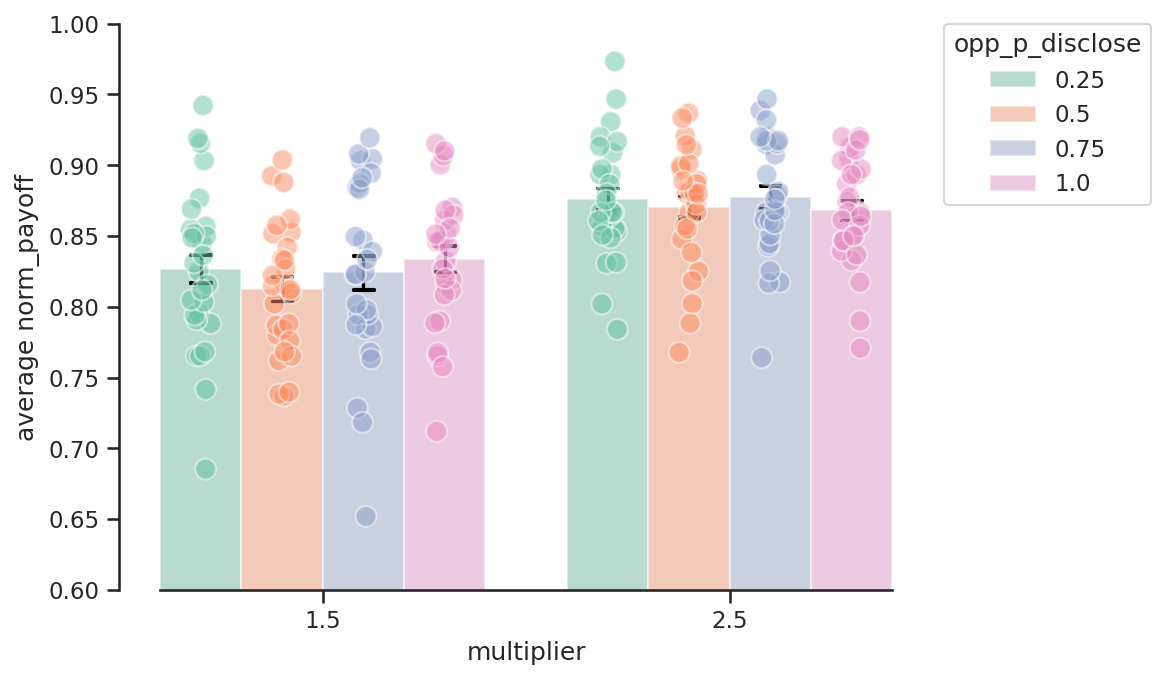

In [ ]:
selected_exp = 3
df = dfs[selected_exp]

vi = 'opp_p_disclose'
vd = 'norm_payoff'

fig, ax = plt.subplots(figsize=(7, 5))

df2 = df.groupby(['prolific_id', 'multiplier',
                    vi], as_index=False)[vd].mean()

sns.set_palette("Set2")

sns.barplot(
    x='multiplier',
    y=vd,
    hue=vi, data=df2, ci=68,
    edgecolor="white",
    errcolor="black",
    errwidth=1.5,
    capsize=0.05, 
    alpha=0.5, ax=ax, zorder=1)

# sns.pointplot()
sns.stripplot(
    x='multiplier',
     y=vd, hue=vi, data=df2, dodge=True,
              jitter=True, ax=ax, alpha=0.5, size=10, edgecolor='white', linewidth=1, zorder=5)

sns.barplot(
   x='multiplier',
   y=vd,
   hue=vi, data=df2, ci=68,
   edgecolor="white",
   errcolor="black",
   errwidth=1.5,
   capsize=0.05,
   alpha=0., zorder=10)
#


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[4:], labels[8:], title=vi,
          bbox_to_anchor=(1, 1.02), loc='upper left')
sns.despine(right=True, top=True)

plt.ylabel(f'average {vd}')

plt.gca().spines['left'].set_smart_bounds(True)
plt.gca().spines['bottom'].set_smart_bounds(True)

df3 = df.groupby(['prolific_id', 'multiplier'], as_index=False)[vd].mean()

r = pg.ttest(x=df3[df3['multiplier'] == 1.5][vd],
         y=df3[df3['multiplier'] == 2.5][vd])
plt.ylim(.6, 1)
print(r)
pg.mixed_anova(data=df2, dv=vd, between="multiplier", within=vi, subject='prolific_id')


/tmp/ipykernel_1390151/2040947798.py:20: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  plt.gca().spines['left'].set_smart_bounds(True)
/tmp/ipykernel_1390151/2040947798.py:21: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  plt.gca().spines['bottom'].set_smart_bounds(True)


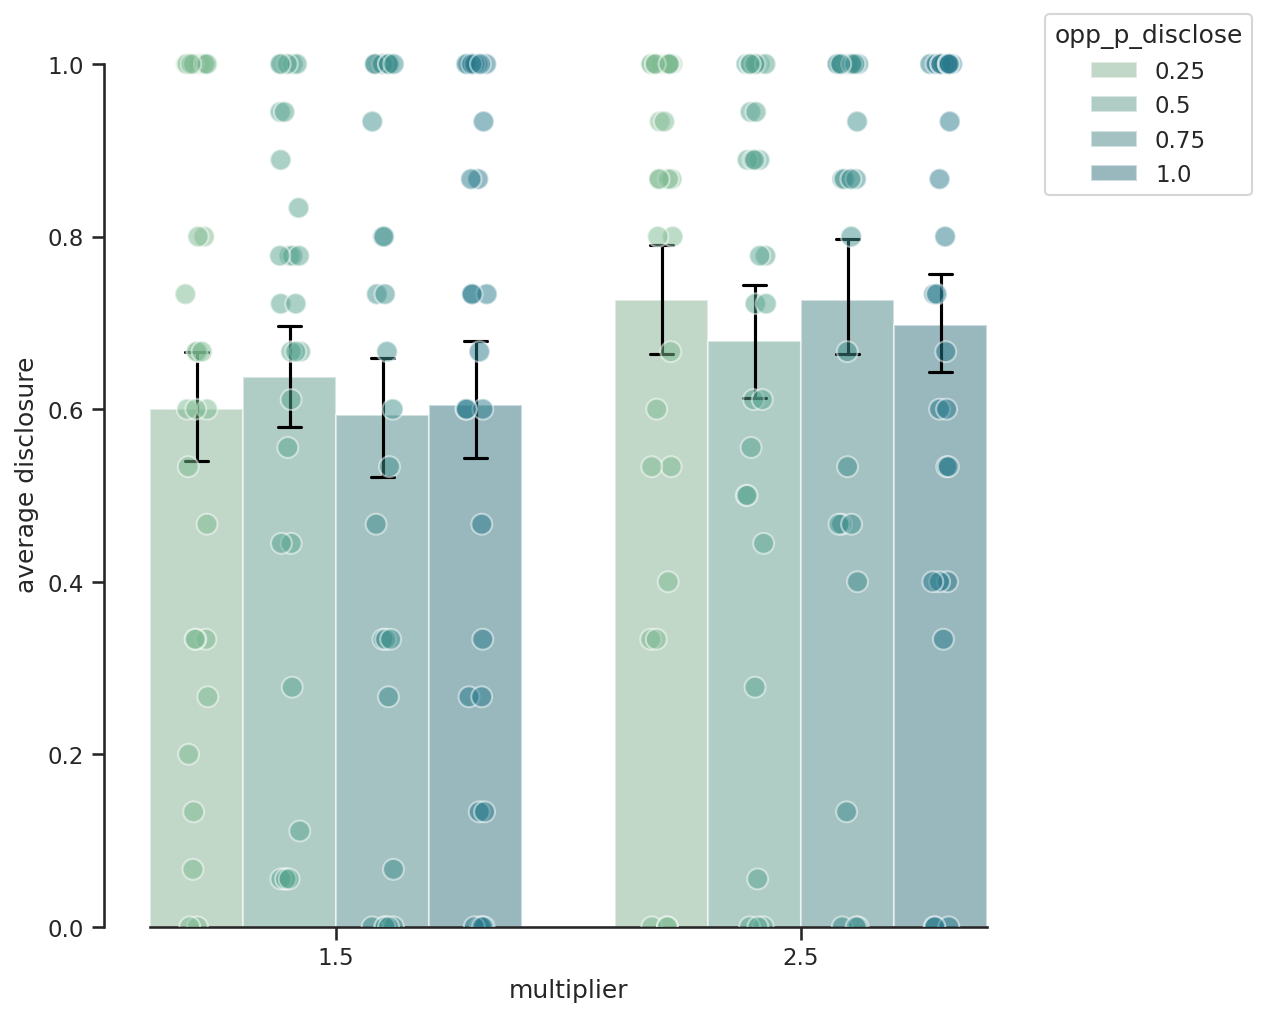

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
df2 = df.groupby(['prolific_id', 'opp_p_disclose', 'multiplier'], as_index=False)['disclose'].mean()

sns.set_palette("crest")
sns.barplot(x='multiplier', y='disclose', hue='opp_p_disclose', data=df2, ci=68, 
    edgecolor="white",
    errcolor="black",
    errwidth=1.5,
    capsize = 0.05,
    alpha=0.5, ax=ax)

sns.stripplot(x='multiplier',y='disclose', hue='opp_p_disclose', data=df2, dodge=True, jitter=True, ax=ax, alpha=0.5, size=10, edgecolor='white', linewidth=1)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[4:], labels[4:], title='opp_p_disclose', bbox_to_anchor=(1, 1.02), loc='upper left')
sns.despine(right=True, top=True)

plt.ylabel('average disclosure')

plt.gca().spines['left'].set_smart_bounds(True)
plt.gca().spines['bottom'].set_smart_bounds(True)



               T        dof       tail     p-val          CI95%   cohen-d  \
T-test -1.386011  20.996024  two-sided  0.180289  [-3.34, 0.67]  0.563018   

         BF10     power  
T-test  0.751  0.248152  


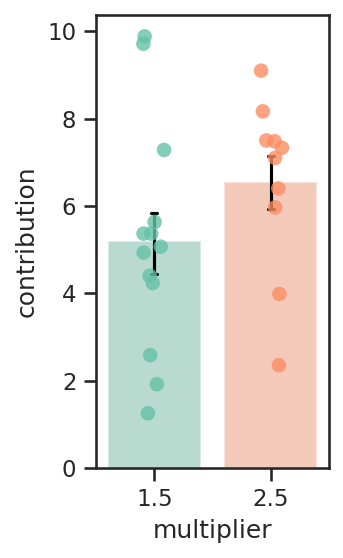

In [ ]:
selected_exp = 2 
df = dfs[selected_exp]

vd = 'contribution'
fig, ax = plt.subplots(figsize=(2, 4))
df2 = df.groupby(['prolific_id',  'multiplier'], as_index=False)[vd].mean()

sns.barplot(x='multiplier', y=vd, data=df2, ci=68, 
    edgecolor="white",
    errcolor="black",
    errwidth=1.5,
    capsize = 0.05,
    alpha=0.5, ax=ax)

sns.stripplot(x='multiplier',y=vd, data=df2, dodge=True, jitter=True, ax=ax, alpha=0.8, size=7, edgecolor='white',)

r = pg.ttest(x=df2[df2['multiplier'] == 1.5][vd],
         y=df2[df2['multiplier'] == 2.5][vd])
print(r)

# pg.pairwise_ttests(dv='contribution', between='multiplier', within=['opp_multiplier'n ] data=df2, correction='bonf', within_first=True)
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles[4:], labels[4:], title='opp_p_disclose', bbox_to_anchor=(1, 1.02), loc='upper left')

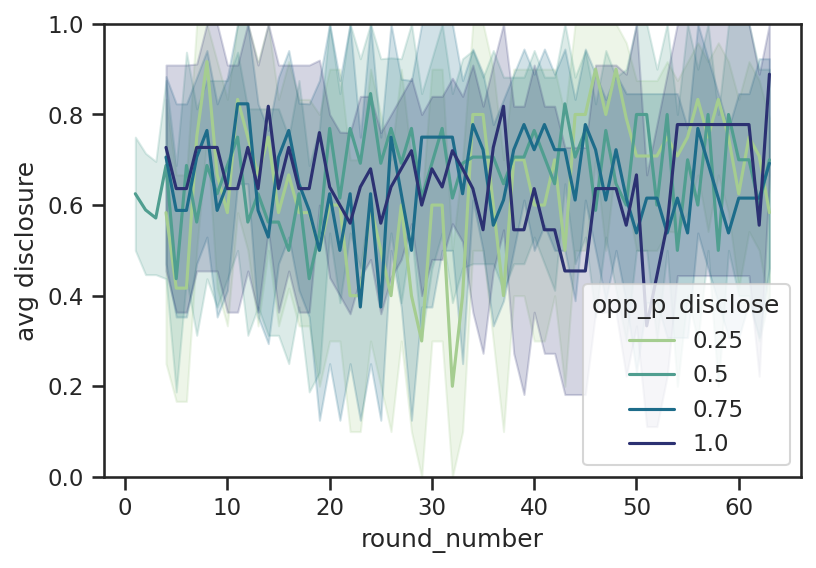

In [ ]:

sns.set_palette("crest")

# Plot the responses for different events and regions
sns.lineplot(x="round_number", y="disclose",
             hue="opp_p_disclose", 
             data=df, palette='crest')
plt.ylim([0, 1])
plt.ylabel('avg disclosure')
plt.show()